In [1]:
%matplotlib widget
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import pandas as pd
import time as ttime

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import radians, log

## Own python package
from synthetics import *

%matplotlib inline
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Developpement"

## Make Nice Plots

In [2]:
plt.style.use("ggplot")
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Theory 

TO DO

## Create Synthetic Waveforms Database Using Syngine

# RUN ONCE !!

In [3]:
## Create station file
if os.path.exists('station_file.txt'):
    print('Station file already exists')
else:
    create_station_file()

Station file already exists


In [4]:
## Create GF Database with Syngine
if os.path.exists('synthetics_iasp91_2s_Z.nc'):
    print('GF archive already exists')
else:
    create_syngine_archive(station_file_path ='station_file.txt')

GF archive already exists


In [5]:
## Create Spectrum Database
if os.path.exists('synthetics_iasp91_2s_Z_spectrum.h5'):
    print('Spectrum archive already exists')
else:
    create_spectrum_archive() 

Spectrum archive already exists


# Synthetics Computation

## Spatial Extent

In [6]:
## Spatial Exent
lon_min = -150
lon_max = -20
lat_min = 0
lat_max = 70

extent = [lon_min, lon_max, lat_min, lat_max]

## Station Pairs and Metadata

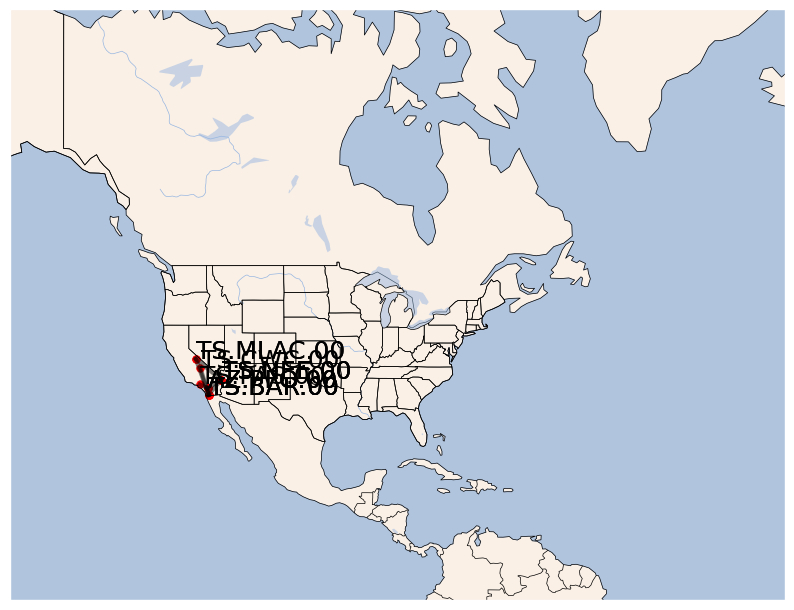

In [7]:
## Station Pairs Metadata
df = pd.read_csv('stations_pair.txt', sep='   ', header=None, index_col=False, names=['idA', 'idB', 'latA', 'latB', 'lonA', 'lonB'], dtype={'idA':str, 'idB':str, 'latA':float, 'latB':float, 'lonA':float, 'lonB':float}, engine='python')
# ## Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAND, color='linen', zorder=0)
ax.add_feature(cfeature.OCEAN, color='lightsteelblue', zorder=0)
for i in range(len(df)):
    ax.annotate(df.idA[i], (df.lonA[i]+0.1, df.latA[i]+0.1), transform = ccrs.PlateCarree(), family = 'sans-serif')
    ax.annotate(df.idB[i], (df.lonB[i]+0.1, df.latB[i]+0.1), transform = ccrs.PlateCarree(), family = 'sans-serif')
    ax.plot((df.lonA[i], df.lonB[i]),(df.latA[i], df.latB[i]), transform = ccrs.PlateCarree(), color='k', alpha=0.5, linewidth=3)
df.plot.scatter(x='lonA', y='latA', s=30, ax=ax, c='r', transform = ccrs.PlateCarree())
df.plot.scatter(x='lonB', y='latB', s=30, ax=ax, c='r', transform = ccrs.PlateCarree())
plt.show()

## Dates 

In [8]:
## Dates
start = datetime(1996, 3, 11, 0, 0, 0)
end = datetime(1996, 4, 9, 0, 0, 0)

dates = pd.date_range(start, end, freq='3H')

dates_vector = create_date_vect(dates)

## Open WAVEWATCHIII Equivalent Force Amplitude

In [9]:
## Open Model
path_model = '../../ocean_source/pr_oceanswell/rayleigh/F/'

## Open Syngine Archive 

In [10]:
## Open GF archive info
fe , freq, time, distance, spectrum_synth = open_archive(h5_name_spectrum='./synthetics_iasp91_2s_Z_spectrum.h5', h5_name_waveforms='./synthetics_iasp91_2s_Z_waveforms.h5')
N_time = len(time)

## Synthetic Cross-correlation Computation

In [11]:
## Compute CCF and save it
### Station Pair Info
id_A = df.idA[0]
id_B = df.idB[0]
coords_staA = (df.lonA[i], df.latA[i])
coords_staB = (df.lonB[i], df.latB[i])

### Date Info
date_vect = dates_vector[0]

### CCF
filename_ccf = './CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]) # File Name Understandable

if os.path.exists(filename_ccf):  # Check if file already exists
    print('%s already computed'%filename_ccf)
    corr = xr.open_dataarray(filename_ccf)
else:  # if not, compute CCF
    t1 = ttime.perf_counter()
    corr, time_corr = ccf_computation(coords_staA, coords_staB, path_model, date_vect, spectrum_synth,extent=extent, fe=fe, N=N_time, comp='Z')
    t2 = ttime.perf_counter()
    print(" Time for station pair: ", station_A, station_B, " elapsed: ", t2-t1)
    corr.to_netcdf('./CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]))

./CCF/ccf_TS.MLAC.00_TS.BAR.00_1996031100.nc already computed


## Plot

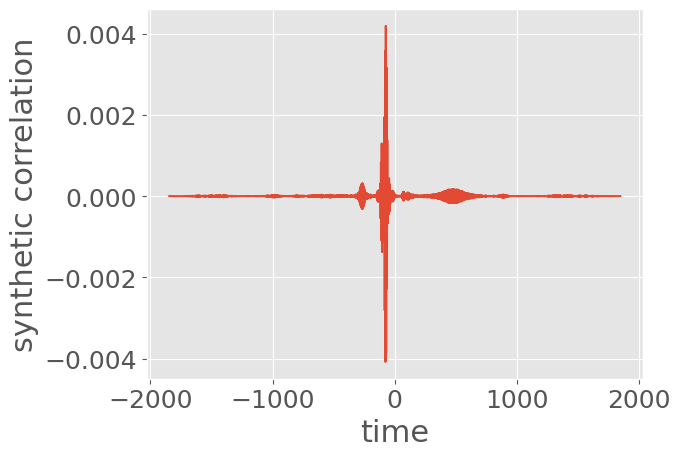

In [12]:
## Plot CCF
corr.plot()
plt.show()